# Example use of the pyem package

In [1]:
# import the Emulator class from pyem
from pyem import Emulator

# we also need pyf3d (you can just copy the pyf3d directory over) ...
from pyf3d import Fall3DInputFile, YesNo

# .. and a few other things
import datetime
import numpy as np

/home/talfan/Documents/projects/dt-geo/ST540103/ST540103/pyem/source.py:611: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_ylabel("Emulator\n$SO_2$ $\mu g m^{-3}$ ")
/home/talfan/Documents/projects/dt-geo/ST540103/ST540103/pyem/source.py:620: SyntaxWarning: invalid escape sequence '\m'
  axs[1].set_ylabel("Emulator RMS error\n$SO_2$ $\mu g m^{-3}$")
/home/talfan/Documents/projects/dt-geo/ST540103/ST540103/pyem/source.py:629: SyntaxWarning: invalid escape sequence '\m'
  axs[2].set_xlabel("$SO_2$  $\mu g m^{-3}$")
/home/talfan/Documents/projects/dt-geo/ST540103/ST540103/pyem/source.py:634: SyntaxWarning: invalid escape sequence '\m'
  axs[2].set_xlabel("Fall3D\n$SO_2$  $\mu g m^{-3}$")


## A simple interpolate-and-sum emulator for a linear forward model

In [2]:
# first we need the base Fall3D input file, which will be modified for each run used
# to build the emulator ...

# ... we load the basefile into memory and change a few things ..
file = Fall3DInputFile.from_file("examples/default_so2_reykjanes2.inp")


# ... we change the base date ...
file.time_utc.update({
    'year':2021,
    'month':7,
    'day':18,
    'run_start':0,
    'run_end':48,
})

# ... update a few details about the meteorological data ...
file.meteo_data.update({
    'dbs_end_meteo_data':48,
    'meteo_coupling_interval':3*60,
    'meteo_data_file':'mnt/runs/tests3/test3.nc',
    'meteo_data_dictionary_file':'/home/talfan/Software/Fall3D/RUNS/CARRA.tbl',
    'meteo_levels_file':"/home/talfan/Software/Fall3D/RUNS/L137_ECMWF.levels"
     
})

# ... add the file containing the locations of the specific ground stations we want to 
# keep track of ...
file.model_output.update({
    'output_track_points_file':'examples/stations.pts'
})

# ... some random other stuff just for the example ..
file.model_physics.update({
    'limiter':'MINMOD'
})

# we want to make sure all stochastic options are set to "no" or "off", so that
# the model will always give the same outputs for the same inputs. This is because
# (1) uncertainty is handles by the Bayesian franmework we are using the emulator within, and
# (2) we want to be able to compare emulator performance with that of a reall Fal3D run
file.emsemble_postprocess.update({
    'postprocess_median':YesNo('no')
})

# ... and we set the mass flow rate to 1.0, because the emulator will scale this by the flux we want.
file.source.update({
    'mass_flow_rate':"1.0"
})

WARNING sigma_values_currently_disabled


In [3]:
# Now we have a starting file, we create an emulator object ...
em = Emulator(
        # ... this is the base Fall3D file we just created - it sets the values for options the 
        # emulatror doesn't change (everything except, heigh flux and source_start, basically)
        basefile=file,

        # the starting date for our emulator ...
        start=datetime.datetime(year=2021,month=7, day=18),

        # ... the duration that our emulatort will simulate, in hours ...
        hours=24,

        # ... the heights for whichy our emulatior will be run - 
        # This gives the range and resolution of the look up table used
        # for interpolating the ground concentrations associated with a 'puf'
        # emitted at a specific height
        heights = np.arange(
            0, # start
            2550, # stop
            50 # interval (not the number of heights!)
        ).astype(float),

        # the name of the emulator specifies the directory within /mnt/runs/ in which the
        # emulator runs and the dataframe  describing them are saved
        name = "library_test2",

        # path to Fall3D
        path_fall3d = "/home/talfan/Software/Fall3D_local/fall3d/bin/Fall3d.r8.x"
)


In [4]:
# First we initiualise the emulator, which creates a folder for every run
# needed to build the look up table in mnt/runs/<name>
em.initialise()

WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled
WARNING sigma_values_currently_disabled


In [5]:
# fetches meteo data for each run
em.get_meteo_data()

  0%|                                                  | 0/1173 [00:00<?, ?it/s]

WARNING sigma_values_currently_disabled
Local file found: mnt/archive/202107_337.0_338.5_63.7_64.2__CARRA.nc


  1%|▎                                         | 7/1173 [00:00<00:55, 21.11it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

  2%|▋                                        | 19/1173 [00:00<00:28, 40.17it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

  3%|█                                        | 31/1173 [00:00<00:23, 48.81it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

  4%|█▌                                       | 43/1173 [00:01<00:21, 53.11it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

  5%|█▉                                       | 55/1173 [00:01<00:20, 55.02it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

  6%|██▎                                      | 67/1173 [00:01<00:19, 56.00it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

  7%|██▊                                      | 79/1173 [00:01<00:19, 55.93it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

  8%|███▏                                     | 91/1173 [00:01<00:19, 56.34it/s]

File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipp

  9%|███▌                                    | 103/1173 [00:02<00:18, 56.61it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 10%|███▉                                    | 115/1173 [00:02<00:18, 56.54it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 11%|████▎                                   | 127/1173 [00:02<00:18, 56.83it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 12%|████▋                                   | 139/1173 [00:02<00:18, 56.71it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 13%|█████▏                                  | 151/1173 [00:02<00:18, 56.76it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 14%|█████▌                                  | 163/1173 [00:03<00:17, 56.89it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 15%|█████▉                                  | 175/1173 [00:03<00:17, 56.62it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 16%|██████▍                                 | 187/1173 [00:03<00:17, 56.99it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 17%|██████▊                                 | 199/1173 [00:03<00:17, 56.80it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 18%|███████▏                                | 211/1173 [00:04<00:16, 56.99it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 19%|███████▌                                | 223/1173 [00:04<00:16, 56.85it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 20%|████████                                | 235/1173 [00:04<00:16, 57.10it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 21%|████████▍                               | 247/1173 [00:04<00:16, 57.11it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 22%|████████▊                               | 259/1173 [00:04<00:16, 57.11it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 23%|█████████▏                              | 271/1173 [00:05<00:15, 57.03it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 24%|█████████▋                              | 283/1173 [00:05<00:15, 57.10it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 25%|██████████                              | 295/1173 [00:05<00:15, 56.39it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 26%|██████████▍                             | 307/1173 [00:05<00:15, 57.12it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 27%|██████████▉                             | 319/1173 [00:05<00:14, 57.37it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 28%|███████████▎                            | 331/1173 [00:06<00:15, 53.75it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 29%|███████████▋                            | 343/1173 [00:06<00:14, 55.45it/s]

File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipp

 30%|████████████                            | 355/1173 [00:06<00:14, 56.42it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 31%|████████████▌                           | 367/1173 [00:06<00:14, 56.94it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 32%|████████████▉                           | 379/1173 [00:06<00:13, 57.35it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 33%|█████████████▎                          | 391/1173 [00:07<00:13, 57.40it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 34%|█████████████▋                          | 403/1173 [00:07<00:13, 57.50it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 35%|██████████████▏                         | 415/1173 [00:07<00:13, 57.50it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 36%|██████████████▌                         | 427/1173 [00:07<00:12, 57.55it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 37%|██████████████▉                         | 439/1173 [00:08<00:12, 57.52it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 38%|███████████████▍                        | 451/1173 [00:08<00:12, 57.25it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 39%|███████████████▊                        | 463/1173 [00:08<00:12, 57.47it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 40%|████████████████▏                       | 475/1173 [00:08<00:12, 57.56it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 42%|████████████████▌                       | 487/1173 [00:08<00:11, 57.54it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 43%|█████████████████                       | 499/1173 [00:09<00:11, 57.48it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 44%|█████████████████▍                      | 511/1173 [00:09<00:11, 57.44it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 45%|█████████████████▊                      | 523/1173 [00:09<00:11, 57.38it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 46%|██████████████████▏                     | 535/1173 [00:09<00:11, 57.32it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 47%|██████████████████▋                     | 547/1173 [00:09<00:10, 56.96it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 48%|███████████████████                     | 559/1173 [00:10<00:11, 55.56it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 49%|███████████████████▍                    | 571/1173 [00:10<00:10, 55.90it/s]

File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipp

 50%|███████████████████▉                    | 583/1173 [00:10<00:10, 56.33it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 51%|████████████████████▎                   | 595/1173 [00:10<00:10, 55.97it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 52%|████████████████████▋                   | 607/1173 [00:10<00:10, 56.55it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 53%|█████████████████████                   | 619/1173 [00:11<00:10, 55.36it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 54%|█████████████████████▌                  | 631/1173 [00:11<00:09, 56.07it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 55%|█████████████████████▉                  | 643/1173 [00:11<00:09, 56.26it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 56%|██████████████████████▎                 | 655/1173 [00:11<00:09, 56.32it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 57%|██████████████████████▋                 | 667/1173 [00:12<00:08, 56.52it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 57%|██████████████████████▉                 | 673/1173 [00:12<00:09, 54.78it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 58%|███████████████████████▎                | 685/1173 [00:12<00:08, 55.93it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 59%|███████████████████████▊                | 697/1173 [00:12<00:08, 56.66it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 60%|████████████████████████▏               | 709/1173 [00:12<00:08, 55.65it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 61%|████████████████████████▌               | 721/1173 [00:12<00:08, 56.30it/s]

File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipp

 62%|████████████████████████▉               | 733/1173 [00:13<00:07, 56.17it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 64%|█████████████████████████▍              | 745/1173 [00:13<00:07, 56.45it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 65%|█████████████████████████▊              | 757/1173 [00:13<00:07, 56.52it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 66%|██████████████████████████▏             | 769/1173 [00:13<00:07, 56.70it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 67%|██████████████████████████▋             | 781/1173 [00:14<00:06, 56.39it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 68%|███████████████████████████             | 793/1173 [00:14<00:06, 55.68it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 69%|███████████████████████████▍            | 805/1173 [00:14<00:06, 56.03it/s]

File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipp

 70%|███████████████████████████▊            | 817/1173 [00:14<00:06, 56.39it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 71%|████████████████████████████▎           | 829/1173 [00:14<00:06, 56.07it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 72%|████████████████████████████▋           | 841/1173 [00:15<00:06, 55.02it/s]

File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipp

 73%|█████████████████████████████           | 853/1173 [00:15<00:05, 55.96it/s]

File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipp

 74%|█████████████████████████████▍          | 865/1173 [00:15<00:05, 56.33it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 75%|█████████████████████████████▉          | 877/1173 [00:15<00:05, 56.86it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 76%|██████████████████████████████▎         | 889/1173 [00:15<00:05, 56.45it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 77%|██████████████████████████████▋         | 901/1173 [00:16<00:04, 56.95it/s]

File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipp

 78%|███████████████████████████████▏        | 913/1173 [00:16<00:04, 57.10it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 79%|███████████████████████████████▌        | 925/1173 [00:16<00:04, 57.48it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 80%|███████████████████████████████▉        | 937/1173 [00:16<00:04, 57.36it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 81%|████████████████████████████████▎       | 949/1173 [00:17<00:03, 57.47it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 82%|████████████████████████████████▊       | 961/1173 [00:17<00:03, 57.52it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 83%|█████████████████████████████████▏      | 973/1173 [00:17<00:03, 57.12it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 84%|█████████████████████████████████▌      | 985/1173 [00:17<00:03, 57.43it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 85%|█████████████████████████████████▉      | 997/1173 [00:17<00:03, 57.52it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 86%|█████████████████████████████████▌     | 1009/1173 [00:18<00:02, 57.43it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 87%|█████████████████████████████████▉     | 1021/1173 [00:18<00:02, 57.33it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 88%|██████████████████████████████████▎    | 1033/1173 [00:18<00:02, 57.16it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 89%|██████████████████████████████████▋    | 1045/1173 [00:18<00:02, 56.94it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 90%|███████████████████████████████████▏   | 1057/1173 [00:18<00:02, 57.19it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 91%|███████████████████████████████████▌   | 1069/1173 [00:19<00:01, 57.52it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 92%|███████████████████████████████████▉   | 1081/1173 [00:19<00:01, 56.22it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 93%|████████████████████████████████████▏  | 1087/1173 [00:19<00:01, 56.52it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 94%|████████████████████████████████████▌  | 1099/1173 [00:19<00:01, 56.85it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 95%|████████████████████████████████████▉  | 1111/1173 [00:19<00:01, 56.84it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 96%|█████████████████████████████████████▎ | 1123/1173 [00:20<00:00, 57.18it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 97%|█████████████████████████████████████▋ | 1135/1173 [00:20<00:00, 57.17it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 98%|██████████████████████████████████████▏| 1147/1173 [00:20<00:00, 54.57it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

 99%|██████████████████████████████████████▌| 1159/1173 [00:20<00:00, 56.02it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

100%|███████████████████████████████████████| 1173/1173 [00:20<00:00, 55.92it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping
WARNING sigma_values_currently_disabled
File already exists: mnt/runs/li

In [6]:
# run everything
em.run()

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless r

-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
-----------------------------------------------------------
                                                           
                                                           
                                                           
                 Initializing FALL3D suite                 
           ______      _      _      ____  _____           
                                                           
          |  ____/\   | |    | |    |___ \|  __ \          
   Copyright: 2018 GNU General Public Li

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
-----------------------------------------------------------
                                                           
                                                           
           ______      _      _      ____  _____           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
          |_|/_/    \_\______|______|____/|_____/          
                                        

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
                                                           
          | |__ /  \  | |    | |      __) | |  | |         
           ______      _      _      ____  _____           
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          |  ____/\   | |    | |    |___ \|  __ \          
          | | / ____ \| |____| |____ ___) | |__| |         
          | |__ /  \  | |    | |      __) | |  | |         
          |_|/_/    \_\______|______|____/|_____/          
          |  __/ /\ \ | |    | |     |__ <| |  | |         
                                                           
          | | / ____ \| |____| |____ ___) | |__| |         
                                        

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
-----------------------------------------------------------
                                                           
                 Initializing FALL3D suite                 
                                                           
                                                           
           ______      _      _      ____  _____           
   Copyright: 2018 GNU General Public License version 3    
          |  ____/\   | |    | |    |___

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
                                                           
          | |__ /  \  | |    | |      __) | |  | |         
           ______      _      _      ____  _____           
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          |  ____/\   | |    | |    |___ \|  __ \          
          | | / ____ \| |____| |____ ___) | |__| |         
          | |__ /  \  | |    | |      __) | |  | |         
          |_|/_/    \_\______|______|____/|_____/          
          |  __/ /\ \ | |    | |     |__ <| |  | |         
                                                           
          | | / ____ \| |____| |____ ___) | |__| |         
                                        

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
                                                           
          | |__ /  \  | |    | |      __) | |  | |         
           ______      _      _      ____  _____           
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          |  ____/\   | |    | |    |___ \|  __ \          
          | | / ____ \| |____| |____ ___) | |__| |         
          | |__ /  \  | |    | |      __) | |  | |         
          |_|/_/    \_\______|______|____/|_____/          
          |  __/ /\ \ | |    | |     |__ <| |  | |         
                                                           
          | | / ____ \| |____| |____ ___) | |__| |         
                                        

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running SetDbs task...
 Running SetSrc task...
 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
                                                           
          | |__ /  \  | |    | |      __) | |  | |         
           ______      _      _      ____  _____           
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          |  ____/\   | |    | |    |___ \|  __ \          
          | | / ____ \| |____| |____ ___) | |__| |         
          | |__ /  \  | |    | |      __) | |  | |         
          |_|/_/    \_\______|______|____/|_____/          
          |  __/ /\ \ | |    | |     |__ <| |  | |         
                                                           
          | | / ____ \| |____| |____ ___) | |__| |         
                                        

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
-----------------------------------------------------------
                                                           
                                                           
           ______      _      _      ____  _____           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
          |_|/_/    \_\______|______|____/|_____/          
                                        

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
                                                           
          | |__ /  \  | |    | |      __) | |  | |         
           ______      _      _      ____  _____           
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          |  ____/\   | |    | |    |___ \|  __ \          
          | | / ____ \| |____| |____ ___) | |__| |         
          | |__ /  \  | |    | |      __) | |  | |         
          |_|/_/    \_\______|______|____/|_____/          
          |  __/ /\ \ | |    | |     |__ <| |  | |         
                                                           
          | | / ____ \| |____| |____ ___) | |__| |         
                                        

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 Running FALL3D solver...
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (C

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
           ______      _      _      ____  _____           
                                                           
          |  ____/\   | |    | |    |___ \|  __ \          
                 Initializing FALL3D suite                 
          | |__ /  \  | |    | |      __) | |  | |         
                                        

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


 Running FALL3D solver...


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


Batch completed


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


In [4]:
# processes the data needed for emulating ground concentration on a lat lon grid
em.build_surface_emulator()

In [5]:
# processes the data needed for emulating groiund concentrations at specific points (specified by stations.pts)
em.build_station_emulator()

In [6]:
# processes the data needed for emulating total column gas content on a lat lon grid
em.build_col_mass_emulator()

In [7]:
# runs Fall£d with a random timeseries of Eruption Source Parameters (ESPs) for comparison with emulator output
em.get_emulator_diagnostics(height_low=125.0, height_high=500.0)

WARNING sigma_values_currently_disabled


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test2/shared_meteo_data.nc , skipping



hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

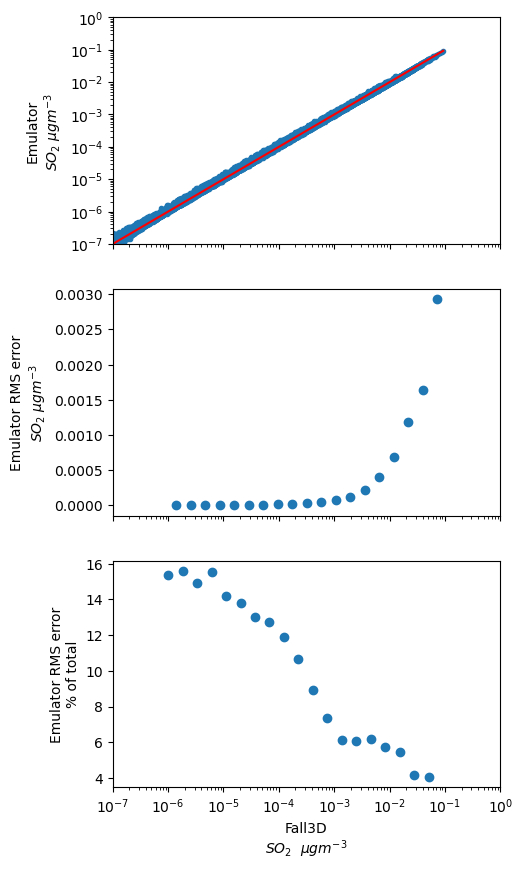

In [8]:
# Plot comparison between emulator and Fall3D for random ESPs
em.plot_emulator_diagnostics()

In [9]:
# save emulator to netcdf
em.to_netcdf("dt5404_example2.nc");

In [10]:
# load emulator from netdcf
new_em = Emulator.from_netcdf("dt5404_example2.nc")

WARNING sigma_values_currently_disabled


## A more complicated neural network based emulator

In [6]:
# UNDER DEVELOPMENT!